In [2]:

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
datasetPath = '/content/drive/My Drive/dataset/names.txt'
words = open(datasetPath, 'r').read().splitlines()

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)} #a:1
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()} #-->1:a
vocabSiz = len(itos) # len of a Vocabulary
print(itos)
print(vocabSiz)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
def buildDataset(words):
    blocksiz = 3 #trigram
    X, Y = [], []
    for w in words:
        contxt = [0] * blocksiz
        for ch in w + '.':
            ix = stoi[ch]
            X.append(contxt)
            Y.append(ix)
            conxtxt = contxt[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

xTrain, yTrain = buildDataset(words[:n1])
xDev, yDev = buildDataset(words[n1:n2])
xTest, yTest = buildDataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
# MLP
nEmb = 10 #the dim of the charatcter embeding vec
nHidden = 200 # num of Neuron in hidden layers
blocksiz = 3 #trigram

#parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocabSiz, nEmb,              generator=g) #10 dims
w1 = torch.randn((nEmb * blocksiz), nHidden, generator=g) #10*3=45 cos we've 15dim  3input layer
b1 = torch.randn(nHidden,                    generator=g)
w2 = torch.randn((nHidden, vocabSiz),        generator=g)
b2 = torch.randn(vocabSiz,                   generator=g)

para = [C, w1, b1, w2, b2]
print(sum(p.nelement() for p in para))

for p in para:
    p.requires_grad = True



11897


In [15]:
maxSteps = 60000
batchSiz = 32
loss_i = []

for i in range(maxSteps):
    ix = torch.randint(0, xTrain.shape[0], (batchSiz,), generator=g)
    Xb, Yb = xTrain[ix], yTrain[ix] #batch x/y

    #forwardPass
    emb = C[Xb]
    embCat = emb.view(emb.shape[0], -1) #concatinating the vec
    hlPreReact = embCat @ w1 + b1 # hidden layer pre-activation
    h = torch.tanh(hlPreReact) #hidden layer
    logits = h @ w2 + b2 #output layer
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in para:
        p.grad = None
    loss.backward()

    # learning rate decay
    lr = 0.1 if i < 30000 else 0.01
    for p in para:
        p.data += -lr * p.grad

    if i % 10000 == 0: #print evry once in a while
        print(f'{i:7d}/{maxSteps:7d}: {loss.item():.4f}')
    loss_i.append(loss.log10().item())

      0/  60000: 2.7814
  10000/  60000: 2.8491
  20000/  60000: 3.3728
  30000/  60000: 2.8749
  40000/  60000: 2.6263
  50000/  60000: 3.1167


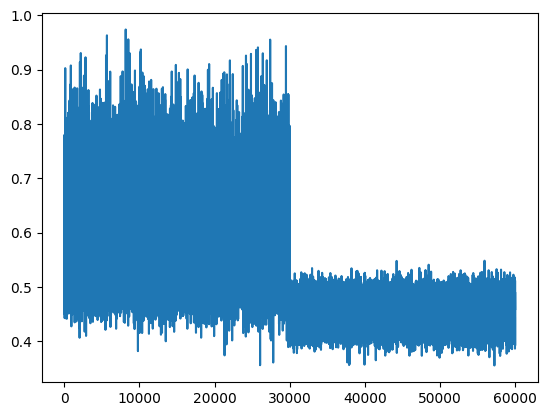

In [16]:
plt.plot(loss_i)


In [17]:
@torch.no_grad()
def splitLoss(split):
    x, y = {
        'train': (xTrain, yTrain),
        'dev': (xDev, yDev),
        'test': (xTest, yTest)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

splitLoss('train')
splitLoss('dev')


train 2.8434484004974365
dev 2.842289924621582


In [18]:
g = torch.Generator().manual_seed(2147483647 + 10)
blocksiz=3
for _ in range(20):
    out = []
    contxt = [0] * blocksiz
    while True:
        emb = C[torch.tensor([contxt])]
        h = torch.tanh(emb.view(1, -1) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        contxt = contxt[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


enhjdixjyrnuhddrwvwyhshojkhgkbdnrzcckhpvkkhgkbdnrzcckhpvkkhojkhgkbdnrzcckhpvkkhojkhgkbdnrhwckfpvzpvkkhgkbynrqbrniovemojkhgkbynrqhs.
srxshvdyhddrwhwzwtksjkhgkbdnrzccshwjkdoewidtksjrhgcbtsofscctfadzdyxvymhjzigdyxvymhjzigdyxvymhjryhcyyshvdixjkcynsrvicoes.
thgfltra.
enhjdixjkcyauhddrwvwyhshojkhgkernhvjyhxjyrnuhddrwvwyhshojkhgkbdnrzccdkshxjyrnuhddrwvwyhshojkhgkbynrrhwvkhhoyy.
thgdfshojkhgkbynrqbrnioewidtksjkhgkbdnrzccvnhguyozvwucoes.
ofwyxshvdyhvzyhodydvevzvhkhojyhguyozvwucovwthsjkhgkbdnrzcckhpvkpvnpgkjdfxwtesjrmhczyikdixjy.
au.
nhlhrzkhojkhgkbdnrzcckhpvkkhgkbdnrzcckhpvkkhgkbdnrzccvnhguyozvwthsjkhgkbynrqbd.
auxjjthxjkcynauxwuldoewikdixjyshvdyhvkoduhczyhodyrhczyikdixjy.
agxjy.
.
nhlhrzkhjktga.
.
jtfgjxrhwvkhhjkdoewidtesjrmhczyikkojnhguyozvwthsjkhgkbdnrzccvnhguyozvwuhjryhcyyshvyyhddrrhwvkhhodydvewaexjkdoewikkoon.
dfsnxshvdyhvzyhcoyhshwjkfauzdtksjkhgkbdnrzcckhpvkkhgkbdnrzcccgfjtrhjdigdyxvymhjzigdyxwvkhhxjyrnuhddrwvwyhshojkhgkbdnrzcckhpvkpvnkxjnhguyozvwthsjkhgkbdnrzccvnhguyozvwthsjkhgkbdnrhwvkh